# Neural Network Mortgage Prepayment Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import time
import imp
import os
import os, os.path
import datetime as dt
import dateutil.parser as dp
import dill
import datetime as dt

%matplotlib inline

## Load data from pkl file

In [2]:
df = pd.read_pickle("../conv_30yr.pkl")

In [3]:
df['Seasonality'] = df['asofdate'].apply(lambda x: int(str(x)[-2:]))

In [4]:
df['jumbo_flag'] = 0

In [5]:
df_jumbos = pd.read_pickle("../jumbos_30yr.pkl")

In [6]:
df_jumbos['Seasonality'] = df_jumbos['asofdate'].apply(lambda x: int(str(x)[-2:]))

In [7]:
df_jumbos['jumbo_flag'] = 1

In [8]:
df = df.append(df_jumbos, ignore_index=True)

### Make sure all the fields (except cusip and poolsno) are numerical and there are no NAs

In [9]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13179842 entries, 0 to 13179841
Data columns (total 112 columns):
 #   Column              Non-Null Count     Dtype  
---  ------              --------------     -----  
 0   poolno              13179842 non-null  object 
 1   asofdate            13179842 non-null  int64  
 2   cusip               13179842 non-null  object 
 3   spread              13179842 non-null  float64
 4   SMM                 13179842 non-null  float64
 5   DayCount            13179842 non-null  float64
 6   OBal                13179842 non-null  float64
 7   CBal                13179842 non-null  float64
 8   factor              13179842 non-null  float64
 9   Coupon              13179842 non-null  float64
 10  Wac                 13179842 non-null  float64
 11  Wam                 13179842 non-null  float64
 12  Age                 13179842 non-null  float64
 13  aols                13179842 non-null  float64
 14  waols               13179842 non-null  float64


In [10]:
# df.to_pickle('../conv_30yr.pkl')

In [11]:
print('df.shape = ', df.shape)

df.shape =  (13179842, 112)


## Model features selection and defining train/test split

* In this section we select which features (columns) are to be used in the model and define a test-train split. 

In [12]:
dummies = pd.get_dummies(df['Seasonality'],drop_first=True)
df = df.drop('Seasonality',axis=1)
df = pd.concat([df,dummies],axis=1)

print(f'df.shape = {df.shape}')

df.shape = (13179842, 122)


In [13]:
list(dummies.columns)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [14]:
model_columns = ['asofdate',
                 'SMM',
                 'jumbo_flag',
                 'spread',
                 'DayCount','factor',
                 'Wac','Wam','Age','aols','waols','CSato',
                 'oltv','cltv','ocltv','ccltv',
                 'fico',
                 '%CashWindow','%Majors',
                 'PurpPct_purchase','PurpPct_refi',
                 'PctChannel_Broker','PctChannel_Corr','PctChannel_Retail',
                 'OccPct_investor','OccPct_owner','PropUnitsPct_2-4',
                
                 # features showing geographical composition of a pool
                 'StatePct_AK','StatePct_AL','StatePct_AR','StatePct_AZ','StatePct_CA','StatePct_CO','StatePct_CT',
                 'StatePct_DC','StatePct_DE','StatePct_FL','StatePct_GA','StatePct_GU','StatePct_HI','StatePct_IA',
                 'StatePct_ID','StatePct_IL','StatePct_IN','StatePct_KS','StatePct_KY','StatePct_LA','StatePct_MA',
                 'StatePct_MD','StatePct_ME','StatePct_MI','StatePct_MN','StatePct_MO','StatePct_MS','StatePct_MT',
                 'StatePct_NC','StatePct_ND','StatePct_NE','StatePct_NH','StatePct_NJ','StatePct_NM','StatePct_NV',
                 'StatePct_NY','StatePct_OH','StatePct_OK','StatePct_OR','StatePct_PA','StatePct_PR','StatePct_RI',
                 'StatePct_SC','StatePct_SD','StatePct_TN','StatePct_TX','StatePct_UT','StatePct_VA','StatePct_VI',
                 'StatePct_VT','StatePct_WA','StatePct_WI','StatePct_WV','StatePct_WY',
                 
                 # features showing originator composition of a pool
                 'SellerPct_AMRHT','SellerPct_ALS','SellerPct_CAFULL','SellerPct_CNTL','SellerPct_CITIZ',
                 'SellerPct_53','SellerPct_FIR','SellerPct_FRDOM','SellerPct_GUILD','SellerPct_CHASE',
                 'SellerPct_LLSL','SellerPct_MATRX','SellerPct_NCM','SellerPct_NATIONST','SellerPct_NRESM',
                 'SellerPct_PNYMAC','SellerPct_PILOSI','SellerPct_QUICK','SellerPct_REG','SellerPct_RMSC',
                 'SellerPct_UNSHFI','SellerPct_WFHM'] + list(dummies.columns)

In [15]:
cnloans = 500 

dfm = df[df['cnloans'] >= cnloans][model_columns]

print(f'dfm.shape = {dfm.shape}')

dfm.shape = (341391, 114)


In [16]:
data_cutoff = 201801

# dfm_train = dfm[dfm['asofdate'] <  data_cutoff]
dfm_train = dfm
dfm_test  = dfm[dfm['asofdate'] >= data_cutoff]

X_train = dfm_train.drop(['SMM','asofdate'],axis=1).values
y_train = dfm_train['SMM'].values

X_test = dfm_test.drop(['SMM','asofdate'],axis=1).values
y_test = dfm_test['SMM'].values

print(f'X_train.shape = {X_train.shape}')
print(f'y_train.shape = {y_train.shape}')
print('\n')
print(f'X_test.shape  = {X_test.shape}')
print(f'y_test.shape  = {y_test.shape}')

X_train.shape = (341391, 112)
y_train.shape = (341391,)


X_test.shape  = (139259, 112)
y_test.shape  = (139259,)


## FF neural-network mortgage prepayment model

* In this section we fit the model to train data

In [17]:
# scale train/test data because buiding a neural net
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout

C:\Users\YuriTurygin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\YuriTurygin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\YuriTurygin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\YuriTurygin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:5

In [19]:
model = Sequential()

model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(8, activation='relu'))
model.add(Dropout(0.4))

#output layer
model.add(Dense(1, activation='relu')) # no activation means linear activation a(x)=x

model.compile(optimizer='adam', loss='mse')
# model.compile(optimizer='rmsprop', loss='mse')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [20]:
model.fit(x=X_train,
          y=y_train,
          validation_data=(X_test,y_test),
          #batch_size=1024,
          epochs=150)

Train on 341391 samples, validate on 139259 samples
Epoch 1/150
341391/341391 [==============================] - 31s 92us/sample - loss: 0.7286 - val_loss: 0.5120
Epoch 2/150
341391/341391 [==============================] - 31s 90us/sample - loss: 0.5703 - val_loss: 0.3667
Epoch 3/150
341391/341391 [==============================] - 31s 90us/sample - loss: 0.5403 - val_loss: 0.5038
Epoch 4/150
341391/341391 [==============================] - 31s 89us/sample - loss: 0.5290 - val_loss: 0.4641
Epoch 5/150
341391/341391 [==============================] - 31s 90us/sample - loss: 0.5217 - val_loss: 0.3259
Epoch 6/150
341391/341391 [==============================] - 32s 94us/sample - loss: 0.5136 - val_loss: 0.5253
Epoch 7/150
341391/341391 [==============================] - 31s 91us/sample - loss: 0.5055 - val_loss: 0.4085
Epoch 8/150
341391/341391 [==============================] - 32s 92us/sample - loss: 0.5015 - val_loss: 0.5369
Epoch 9/150
341391/341391 [==============================] -

341391/341391 [==============================] - 32s 93us/sample - loss: 0.4664 - val_loss: 0.3518
Epoch 74/150
341391/341391 [==============================] - 31s 90us/sample - loss: 0.4650 - val_loss: 0.3472
Epoch 75/150
341391/341391 [==============================] - 31s 91us/sample - loss: 0.4648 - val_loss: 0.3902
Epoch 76/150
341391/341391 [==============================] - 31s 91us/sample - loss: 0.4643 - val_loss: 0.4017
Epoch 77/150
341391/341391 [==============================] - 31s 92us/sample - loss: 0.4658 - val_loss: 0.3632
Epoch 78/150
341391/341391 [==============================] - 31s 90us/sample - loss: 0.4622 - val_loss: 0.3127
Epoch 79/150
341391/341391 [==============================] - 30s 89us/sample - loss: 0.4681 - val_loss: 0.3440
Epoch 80/150
341391/341391 [==============================] - 30s 89us/sample - loss: 0.4695 - val_loss: 0.3559
Epoch 81/150
341391/341391 [==============================] - 31s 90us/sample - loss: 0.4638 - val_loss: 0.4610
Epoch

Epoch 146/150
341391/341391 [==============================] - 31s 91us/sample - loss: 0.4586 - val_loss: 0.3165
Epoch 147/150
341391/341391 [==============================] - 31s 90us/sample - loss: 0.4577 - val_loss: 0.3510
Epoch 148/150
341391/341391 [==============================] - 31s 91us/sample - loss: 0.4571 - val_loss: 0.4261
Epoch 149/150
341391/341391 [==============================] - 31s 91us/sample - loss: 0.4548 - val_loss: 0.3676
Epoch 150/150
341391/341391 [==============================] - 31s 90us/sample - loss: 0.4549 - val_loss: 0.3430


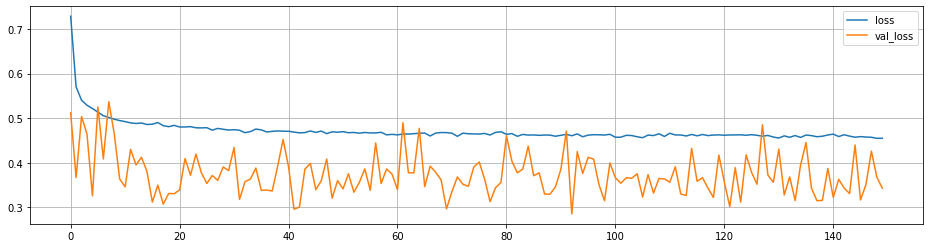

In [21]:
losses = pd.DataFrame(model.history.history)

losses.plot(figsize=(16,4),grid=True)

## Model Evaluation and Validation

* to be updated

### Validation reports

In [22]:
def valReport(dframe,graphTitle='',lcoup=2.5,hcoup=5,fsize=(24,24)):

    ppm_table = dframe[['CBal','model SMM x CBal','SMM x CBal','Coupon','ppmdate']].groupby(['Coupon','ppmdate']).sum()

    ppm_table['SMM'] = ppm_table['SMM x CBal']/ppm_table['CBal']
    ppm_table['CPR'] = 100*(1-(1-ppm_table['SMM']/100)**12)

    ppm_table['model SMM'] = ppm_table['model SMM x CBal']/ppm_table['CBal']
    ppm_table['model CPR'] = 100*(1-(1-ppm_table['model SMM']/100)**12)
    
    fig = plt.figure(figsize=fsize)
    
    plt.axis('off')
    
    plt.title(graphTitle)

    numOfsubgraphs = int((hcoup-lcoup)*2 + 1)

    for i in range(numOfsubgraphs):
        ax = fig.add_subplot(numOfsubgraphs,1,i+1)
        coupon = lcoup + i*0.5
        if ('CPR',coupon) in ppm_table.unstack(level=0).columns:
            ppm_table.unstack(level=0)[[('CPR',coupon),('model CPR',coupon)]].plot(ax=ax,grid=True)
            ax.legend()

In [23]:
def rmse_by_coupon(dframe,lcoup=2.5,hcoup=5,col_name='RMSE (CPR)'):
    
    ppm_table = dframe[['CBal','model SMM x CBal','SMM x CBal','Coupon','ppmdate']].groupby(['Coupon','ppmdate']).sum()

    ppm_table['SMM'] = ppm_table['SMM x CBal']/ppm_table['CBal']
    ppm_table['CPR'] = 100*(1-(1-ppm_table['SMM']/100)**12)

    ppm_table['model SMM'] = ppm_table['model SMM x CBal']/ppm_table['CBal']
    ppm_table['model CPR'] = 100*(1-(1-ppm_table['model SMM']/100)**12)
    
    RMSE_by_coupon = dict()
    
    for i in range(int((hcoup-lcoup)*2 + 1)):
        coupon = lcoup + i*0.5
        if ('CPR',coupon) in ppm_table.unstack(level=0).columns:
            act_vs_pred = ppm_table.unstack(level=0)[[('CPR',coupon),('model CPR',coupon)]].dropna()
            RMSE_by_coupon[coupon] = np.sqrt(mean_squared_error(act_vs_pred[('CPR',coupon)],act_vs_pred[('model CPR'),coupon]))
            
    RMSE_by_coupon = pd.DataFrame({col_name:list(RMSE_by_coupon.values())},index=RMSE_by_coupon.keys())
    RMSE_by_coupon.index.name = 'Coupon'
    
    return RMSE_by_coupon    

### Validation of a neural-network model on a pool by pool basis.

* to be updated

In [24]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

test_predictions = model.predict(X_test)
print(f'(test set) mean absolute error       = {np.round(mean_absolute_error(y_test,test_predictions),4)}')
print(f'(test set) mean sq root sq error     = {np.round(np.sqrt(mean_squared_error(y_test,test_predictions)),4)}')
print(f'(test set) explained variance score  = {np.round(explained_variance_score(y_test,test_predictions),4)}')
print('\n')
train_predictions = model.predict(X_train)
print(f'(train set) mean absolute error      = {np.round(mean_absolute_error(y_train,train_predictions),4)}')
print(f'(train set) mean sq root sq error    = {np.round(np.sqrt(mean_squared_error(y_train,train_predictions)),4)}')
print(f'(train set) explained variance score = {np.round(explained_variance_score(y_train,train_predictions),4)}')

(test set) mean absolute error       = 0.4152
(test set) mean sq root sq error     = 0.5856
(test set) explained variance score  = 0.824


(train set) mean absolute error      = 0.3892
(train set) mean sq root sq error    = 0.5394
(train set) explained variance score = 0.7852


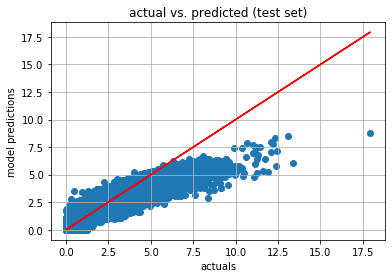

In [25]:
plt.scatter(y_test,test_predictions)
plt.xlabel('actuals')
plt.ylabel('model predictions')
plt.title('actual vs. predicted (test set)')
plt.plot(y_test,y_test,'r'); plt.grid()

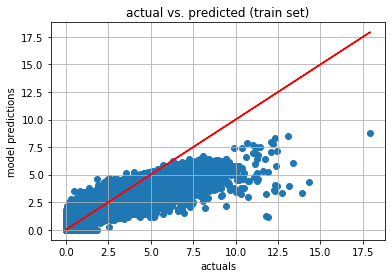

In [26]:
plt.scatter(y_train,train_predictions)
plt.xlabel('actuals')
plt.ylabel('model predictions')
plt.title('actual vs. predicted (train set)')
plt.plot(y_train,y_train,'r'); plt.grid()

In [27]:
# df[(df['SMM'] - df['model SMM'] > 5) & (df['cnloans'] > 500)][['cusip','Wac','spread','Age','asofdate','cnloans','SMM','model SMM']].head(50)

### Validation of a neural network model on large populations of pools/loans

* Here we examine model performance on large populations of loans

In [28]:
df['model SMM'] = model.predict(scaler.transform(df[model_columns].drop(['SMM','asofdate'],axis=1)))

In [29]:
df['SMM x CBal'] = df['SMM']*df['CBal']
df['model SMM x CBal'] = df['model SMM']*df['CBal']
df['ppmdate'] = df['asofdate'].apply(lambda x: dt.date(int(str(x)[:4]),int(str(x)[-2:]),1))
df['Vintage'] = df['pool_issue_month'].apply(lambda x: int(str(x)[:4]))

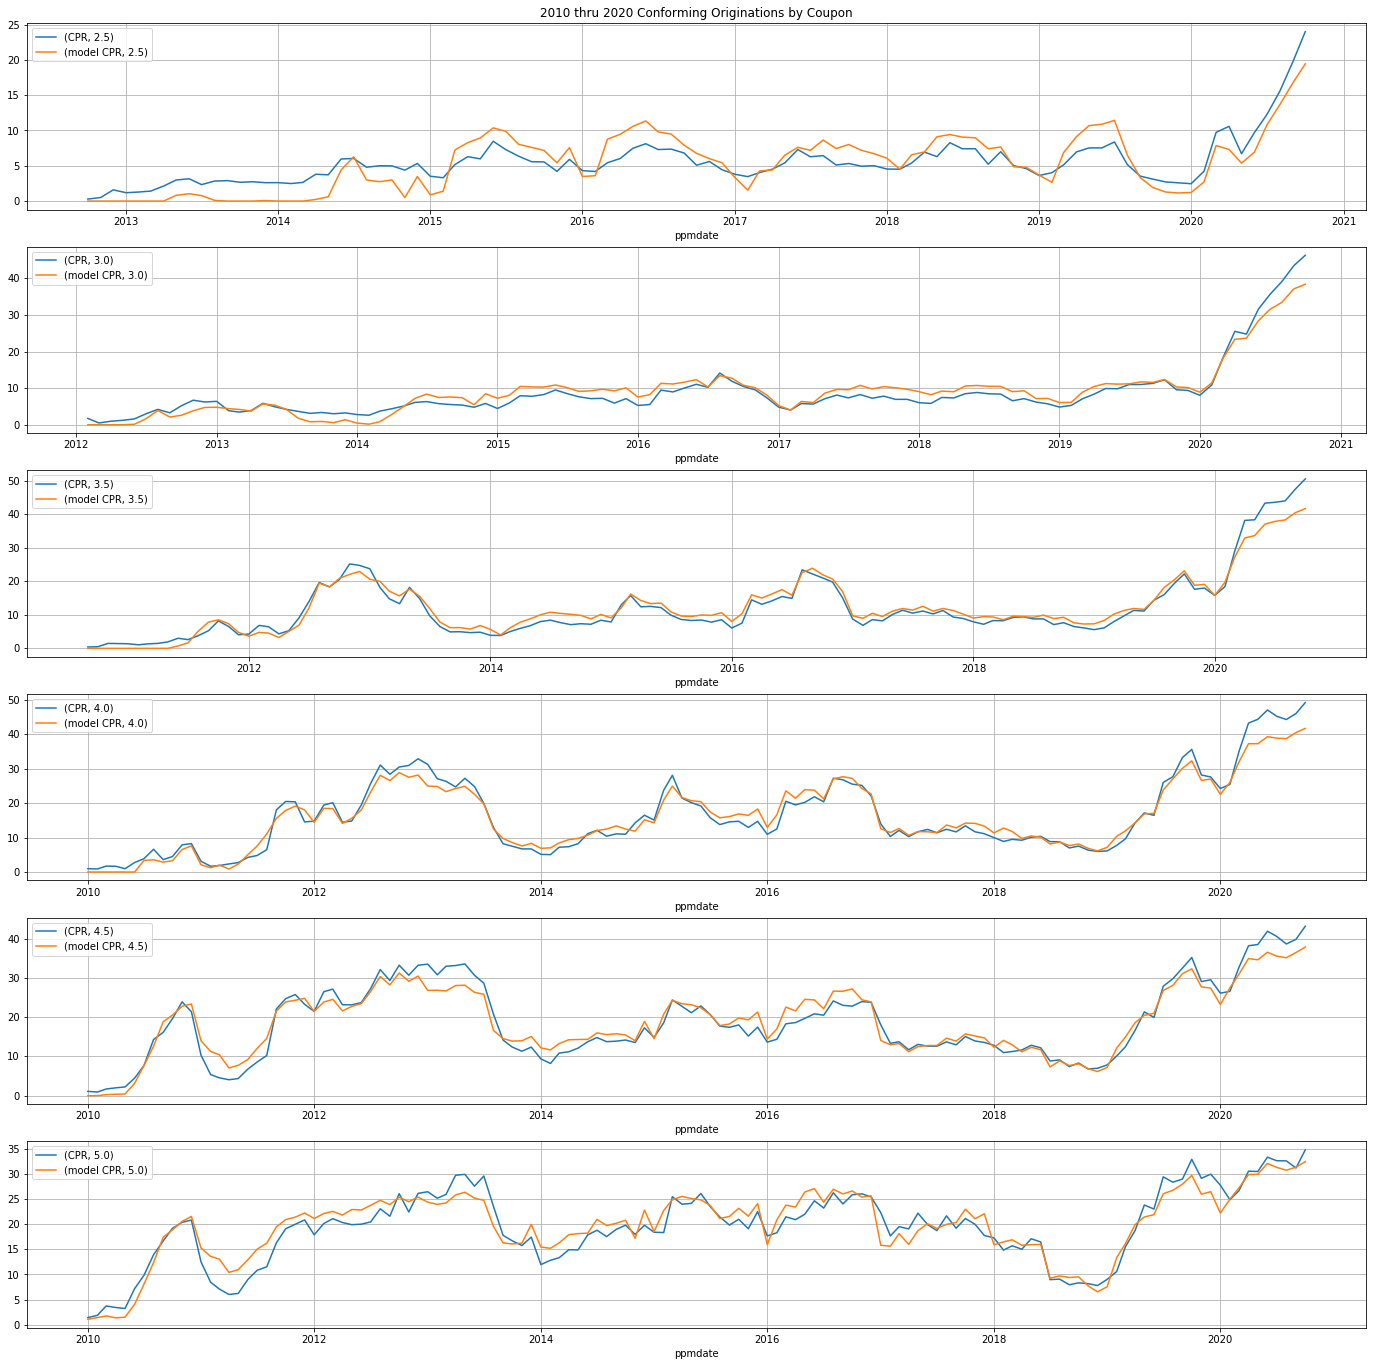

In [30]:
valReport(df[df['cnloans']>=cnloans],graphTitle='2010 thru 2020 Conforming Originations by Coupon',fsize=(24,24))

In [31]:
np.round(rmse_by_coupon(df[(df['cnloans']>=cnloans) & df['asofdate']<data_cutoff],col_name='2010 - 2020 Vintages NN RMSE (CPR)'),2)

,2010 - 2020 Vintages NN RMSE (CPR)
Coupon,
2.5,1.76
3.0,1.95
3.5,2.07
4.0,2.10
4.5,1.94
5.0,1.88


In [32]:
np.round(rmse_by_coupon(df[(df['cnloans']>=cnloans) & (df['asofdate']>=data_cutoff)],col_name='2010 - 2020 Vintages NN RMSE (CPR)'),2)

,2010 - 2020 Vintages NN RMSE (CPR)
Coupon,
2.5,1.99
3.0,2.63
3.5,3.11
4.0,3.36
4.5,2.41
5.0,1.91


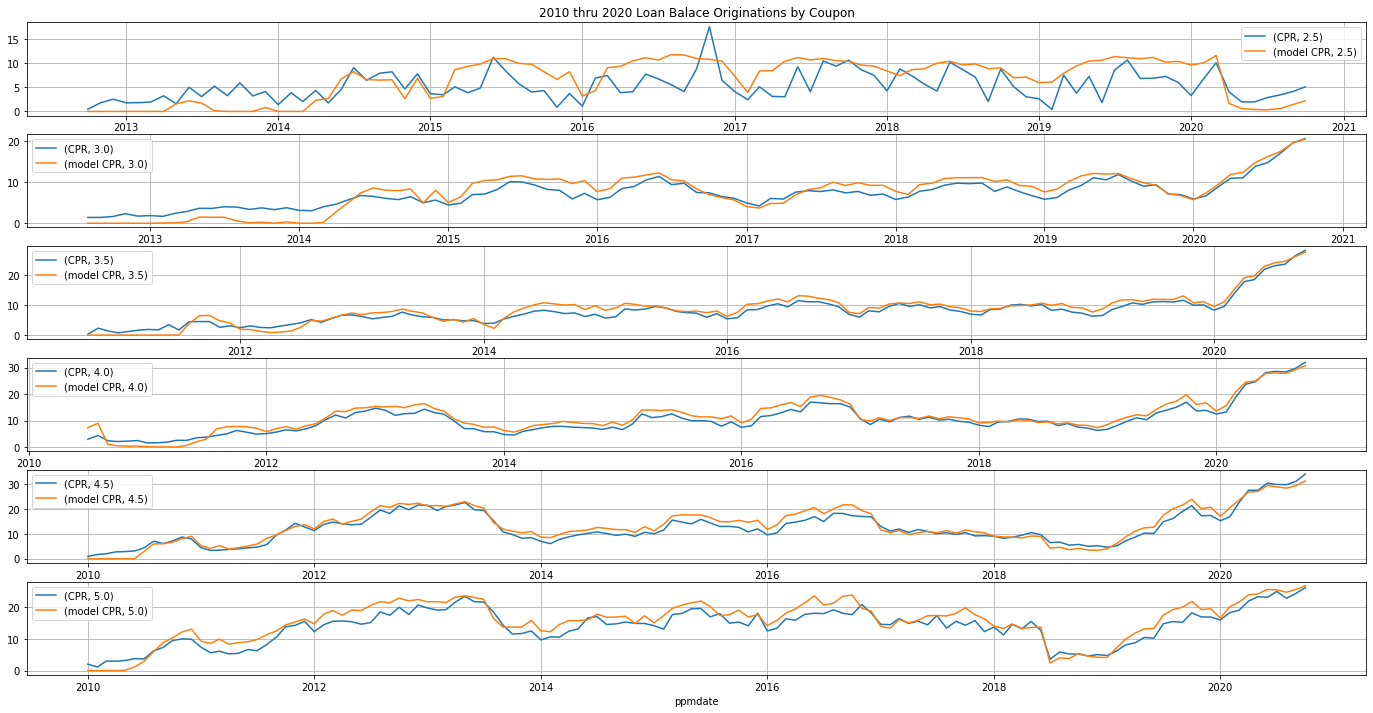

In [33]:
valReport(df[(df['cnloans']>=cnloans) & (df['waols'] <= 200000)],graphTitle='2010 thru 2020 Loan Balace Originations by Coupon',fsize=(24,12))

In [34]:
np.round(rmse_by_coupon(df[(df['cnloans']>=cnloans) & (df['asofdate']>=data_cutoff) & (df['waols'] <= 200000)],col_name='200k max NN RMSE (CPR)'),2)

,200k max NN RMSE (CPR)
Coupon,
2.5,3.71
3.0,1.35
3.5,1.23
4.0,1.42
4.5,1.97
5.0,2.06


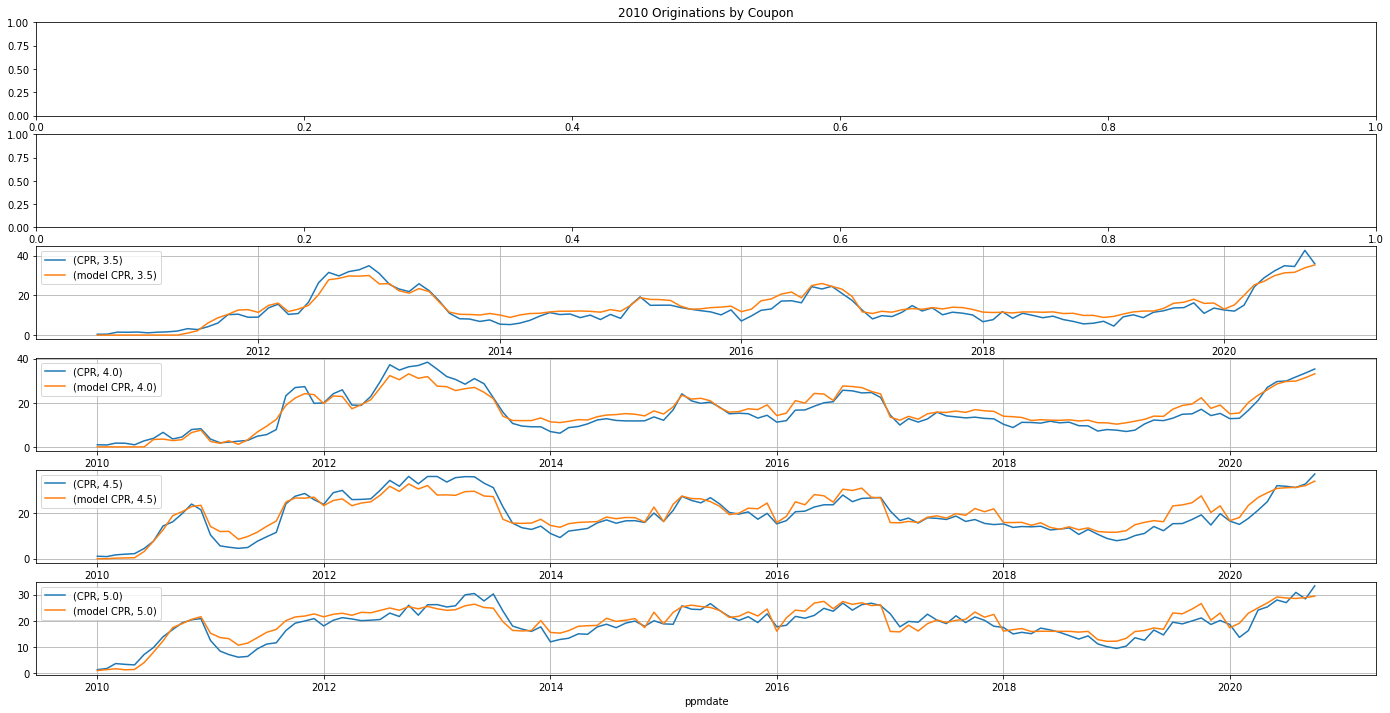

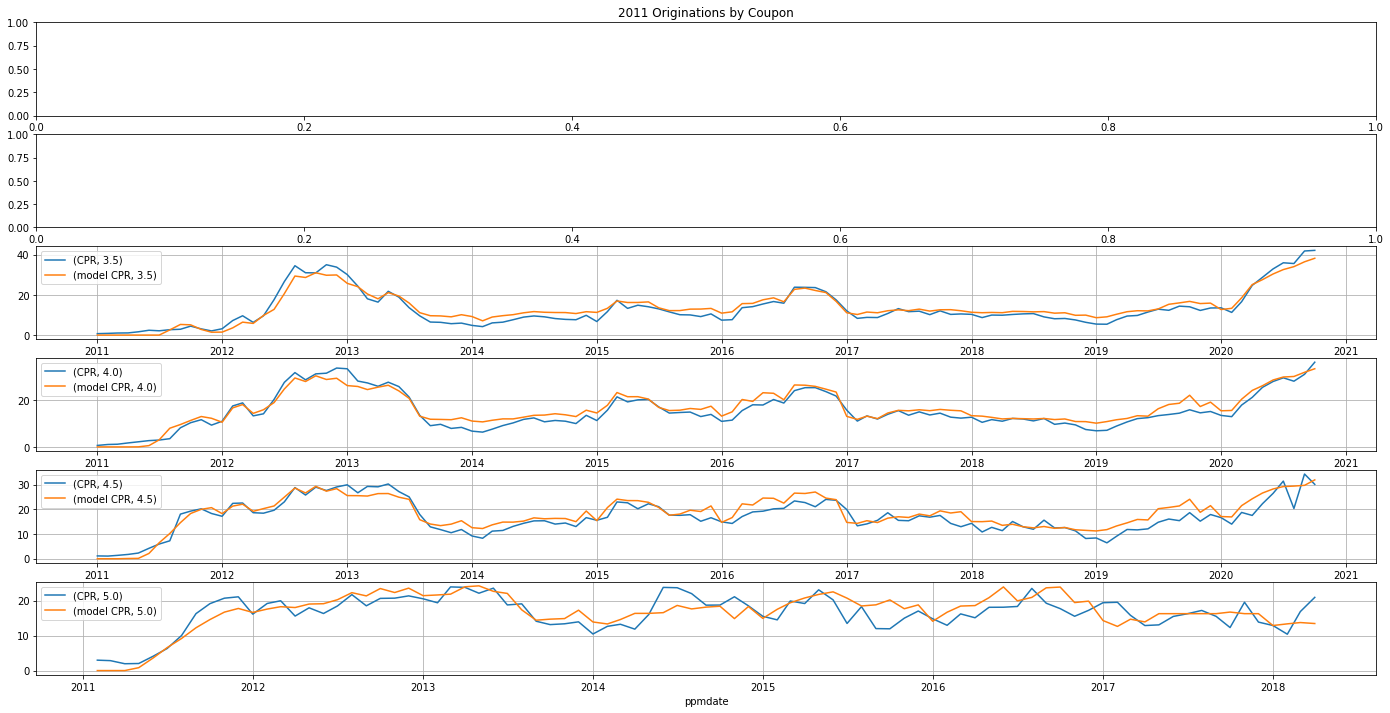

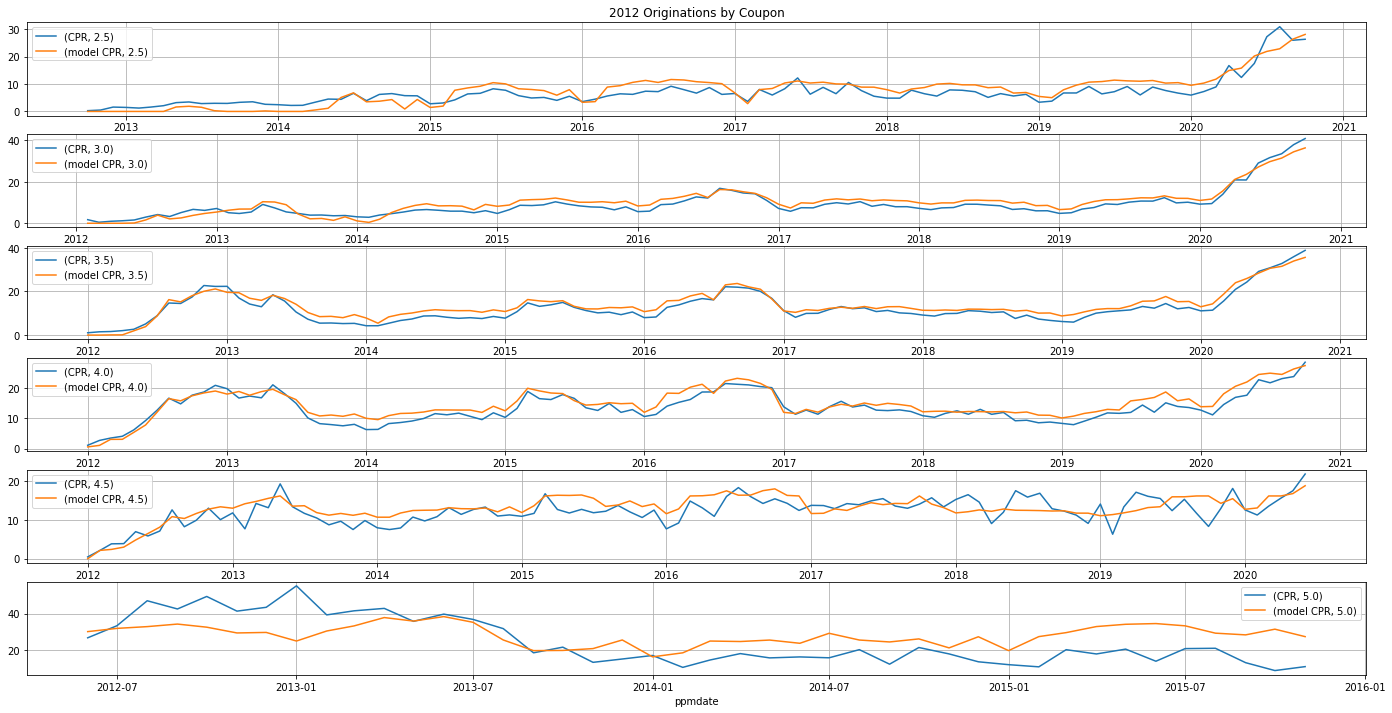

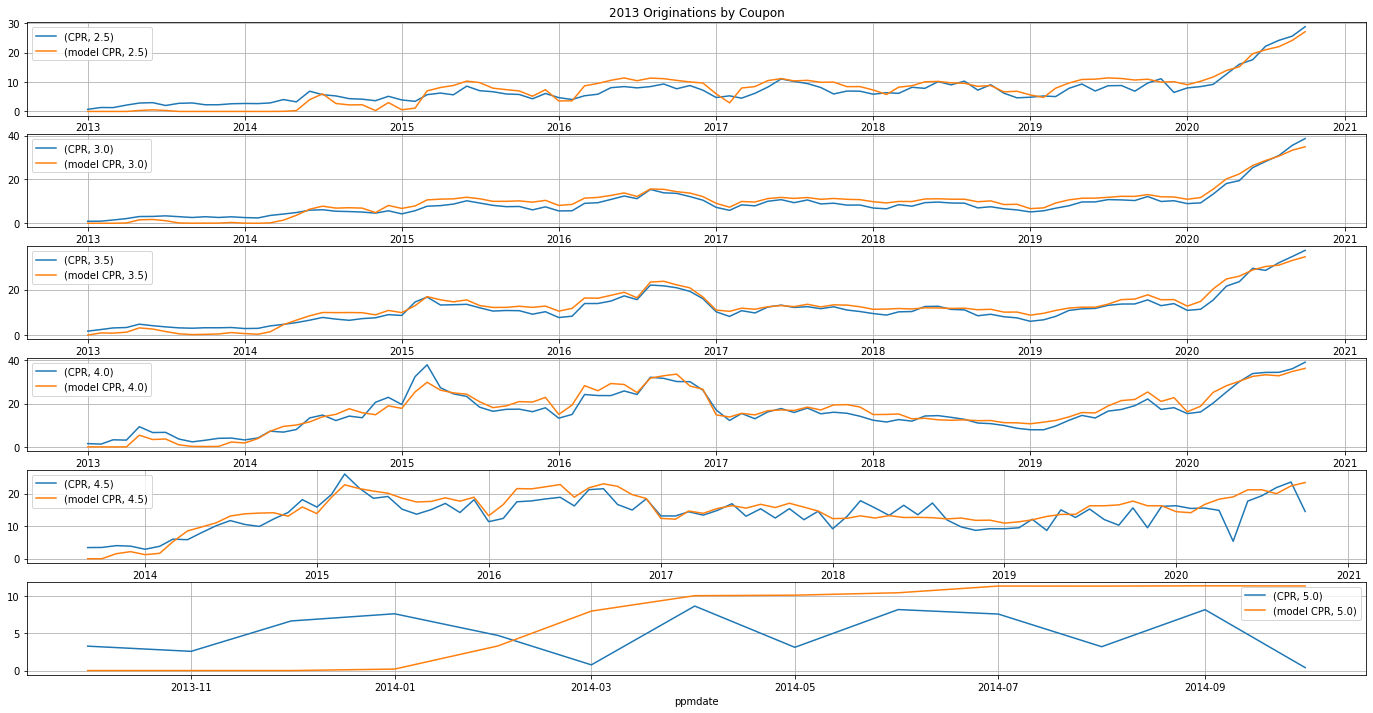

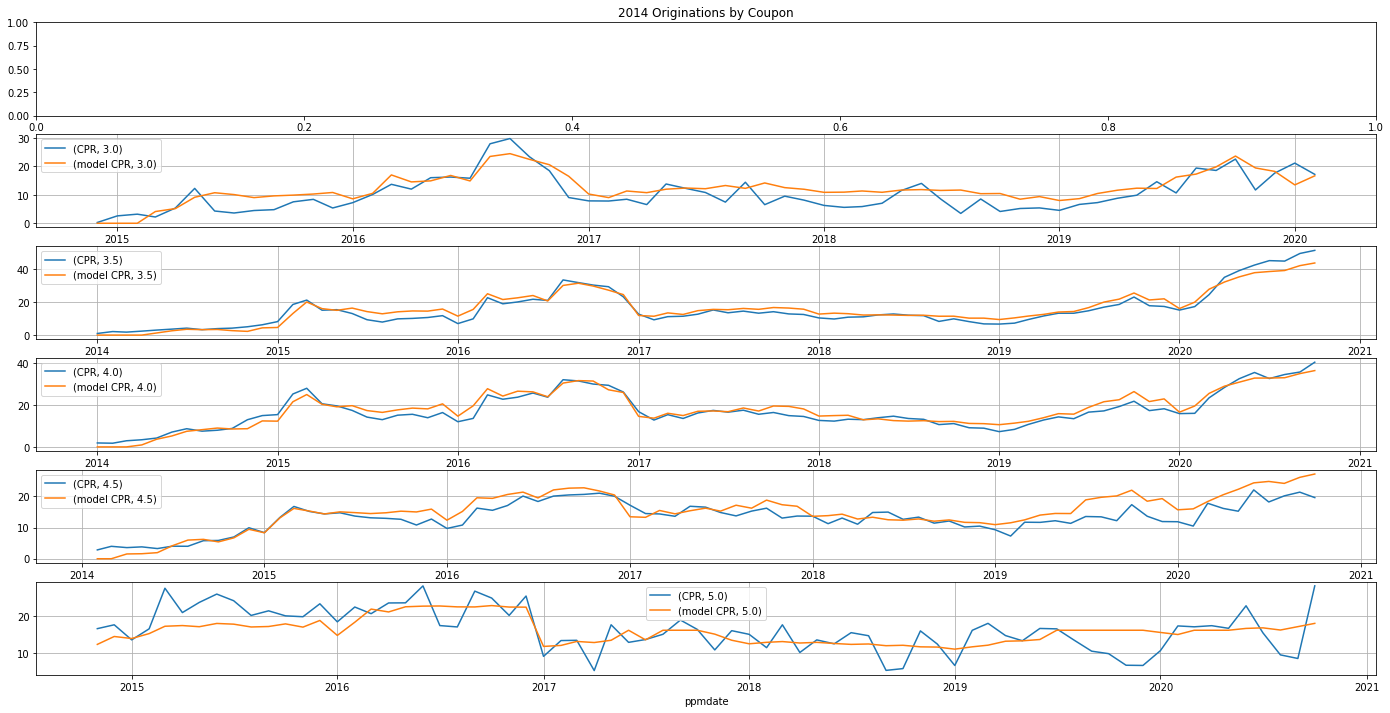

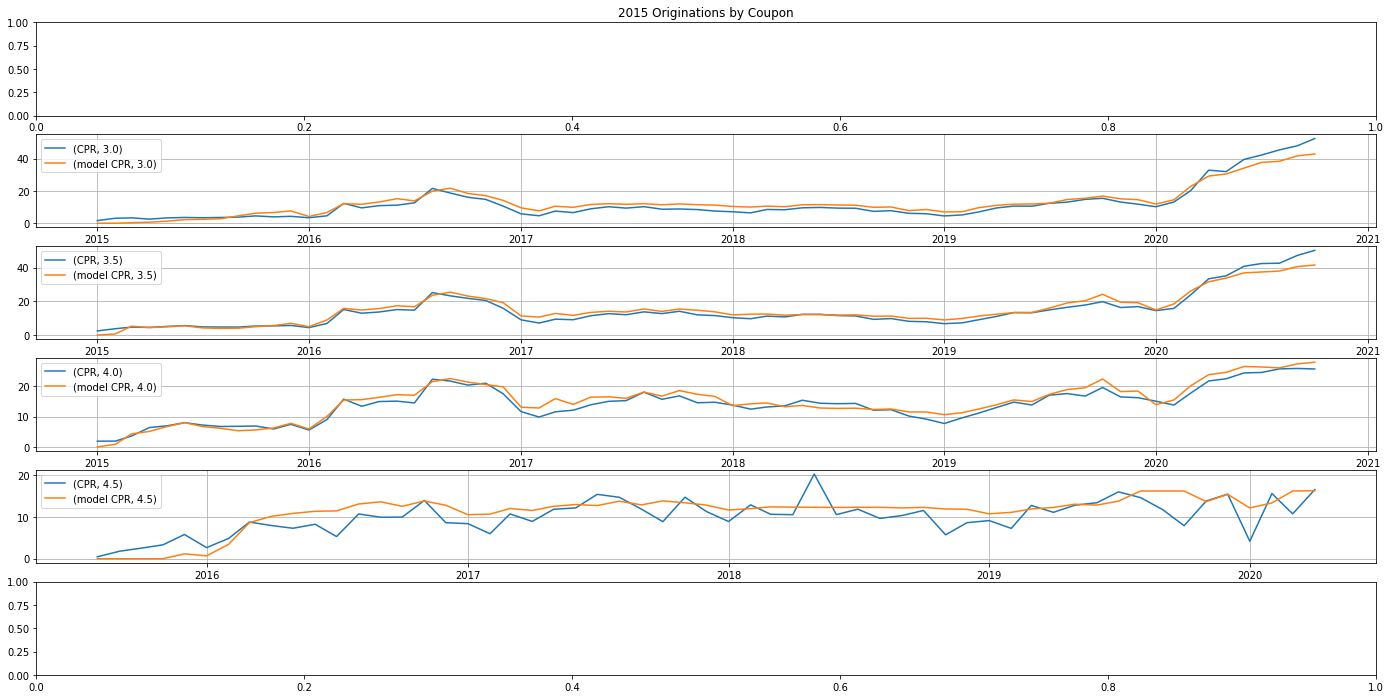

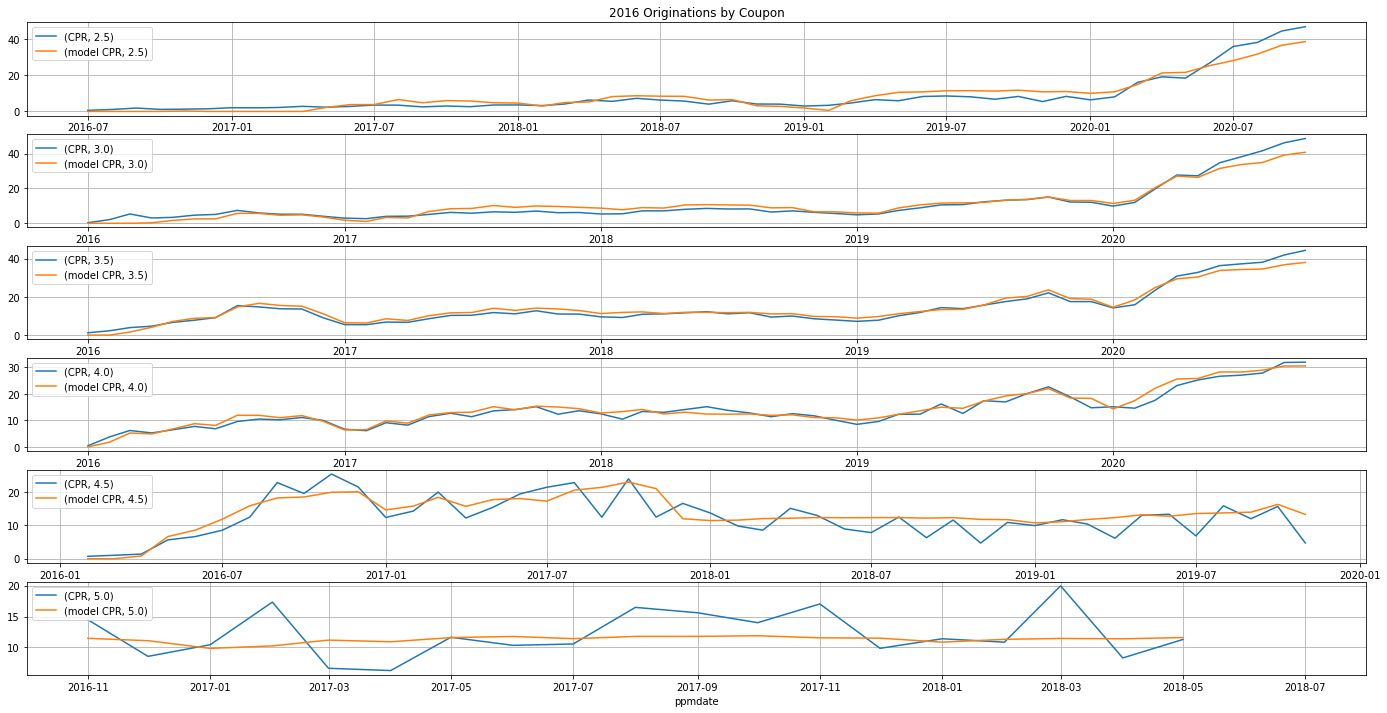

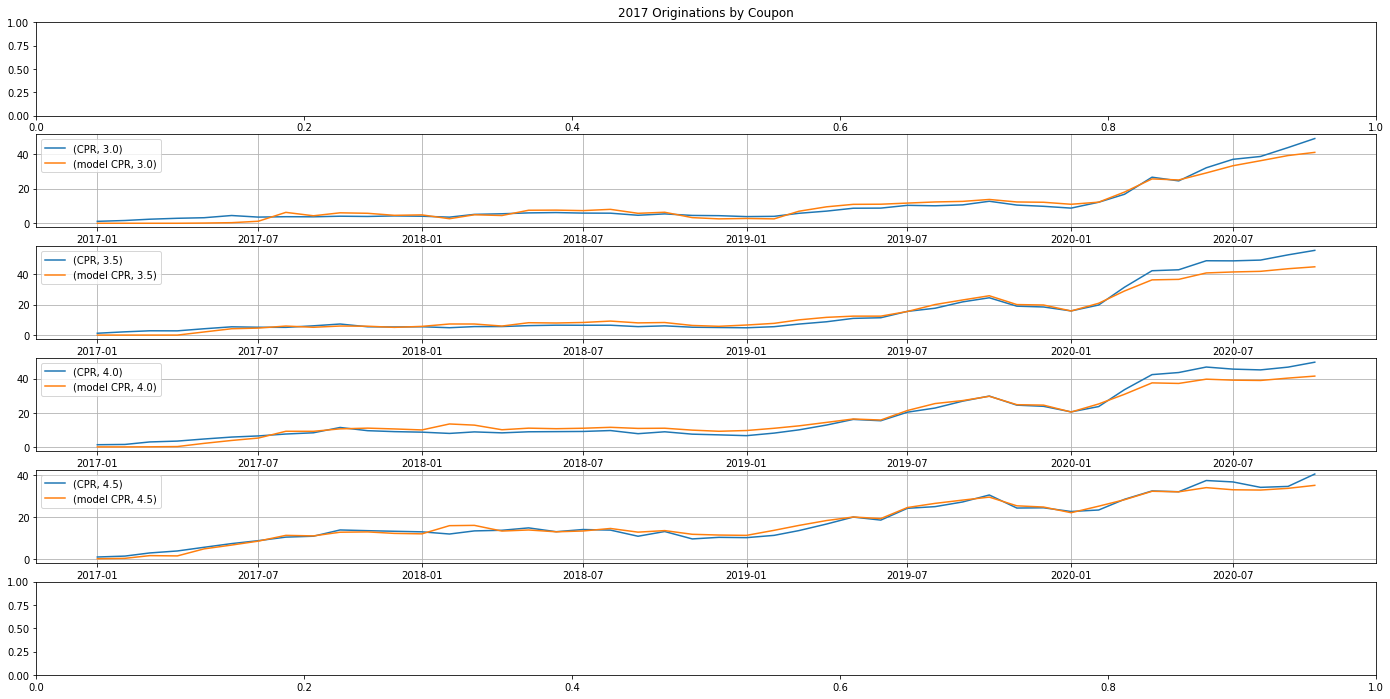

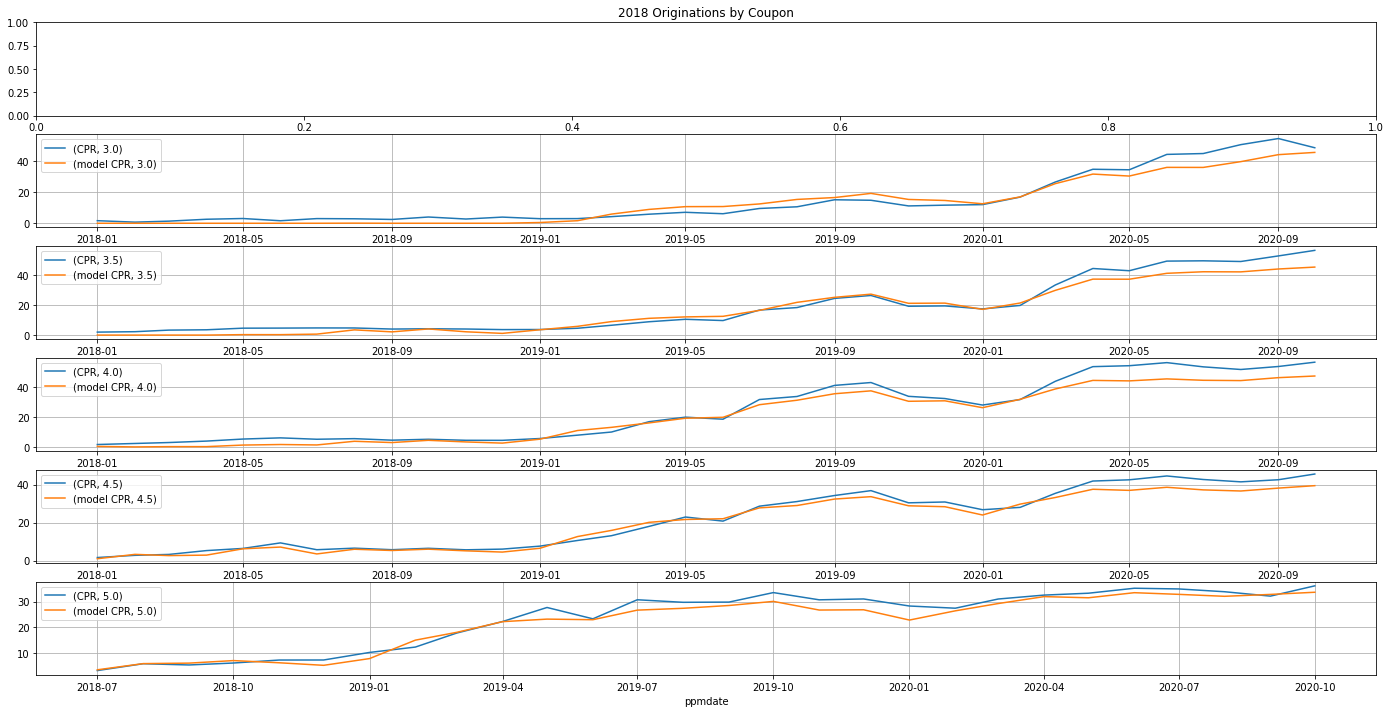

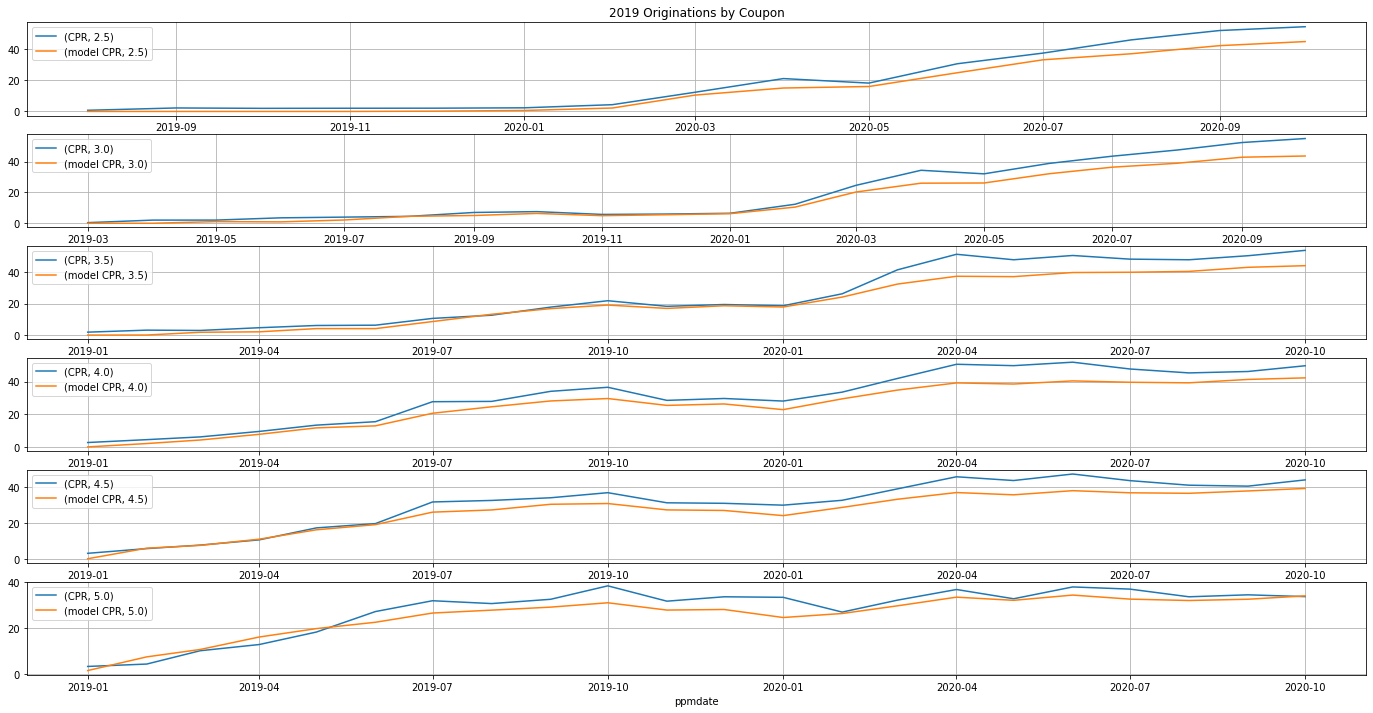

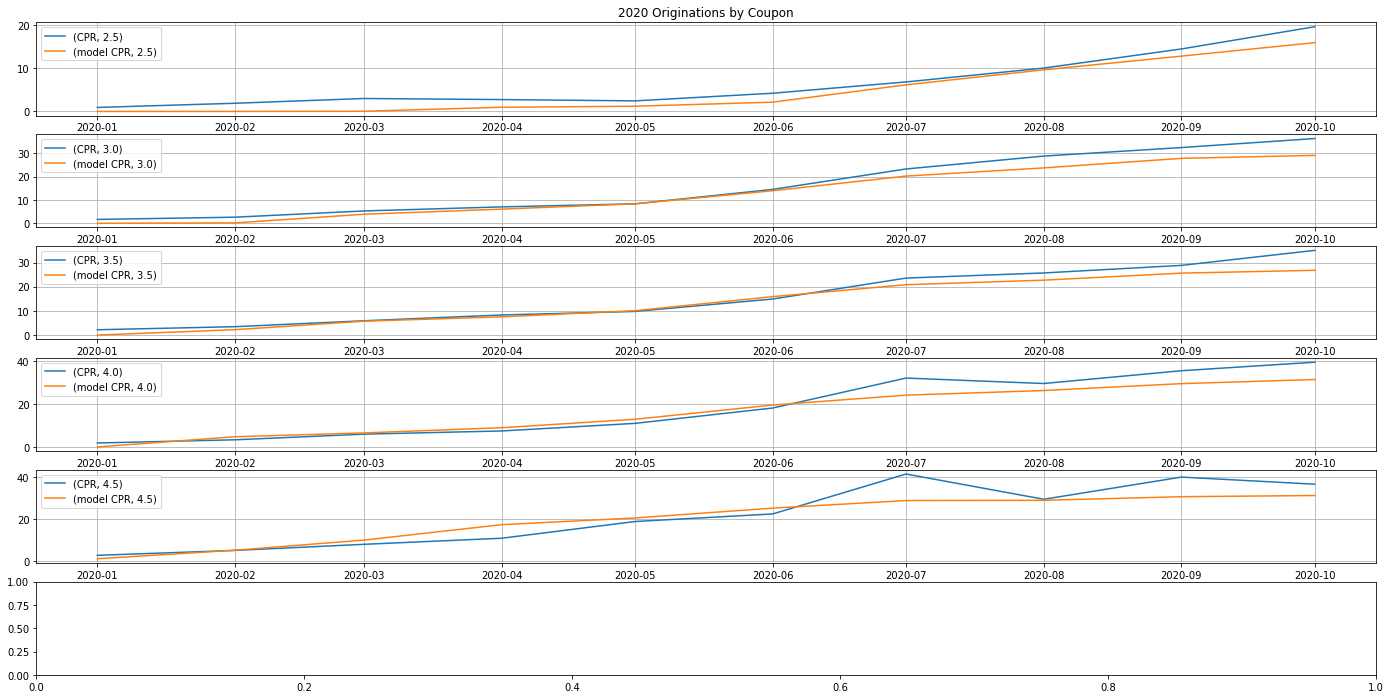

In [35]:
for vintage in [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020]:

    valReport(df[(df['cnloans']>=cnloans) & (df['Vintage'] == vintage)],graphTitle=f'{vintage} Originations by Coupon',fsize=(24,12))

In [36]:
for vintage in [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020]:

    print(np.round(rmse_by_coupon(df[(df['cnloans']>=cnloans) & (df['asofdate']>=data_cutoff) & (df['Vintage'] == vintage)],col_name=f'{vintage} NN RMSE (CPR)'),2))
    print('\n')

        2010 NN RMSE (CPR)
Coupon                    
3.5                   3.23
4.0                   2.88
4.5                   3.88
5.0                   2.77


        2011 NN RMSE (CPR)
Coupon                    
3.5                   2.48
4.0                   2.52
4.5                   3.75
5.0                   4.31


        2012 NN RMSE (CPR)
Coupon                    
2.5                   3.14
3.0                   2.32
3.5                   2.34
4.0                   2.42
4.5                   3.21


        2013 NN RMSE (CPR)
Coupon                    
2.5                   1.90
3.0                   2.07
3.5                   2.14
4.0                   2.50
4.5                   3.98


        2014 NN RMSE (CPR)
Coupon                    
3.0                   4.16
3.5                   3.39
4.0                   2.48
4.5                   4.04
5.0                   4.81


        2015 NN RMSE (CPR)
Coupon                    
3.0                   3.26
3.5               

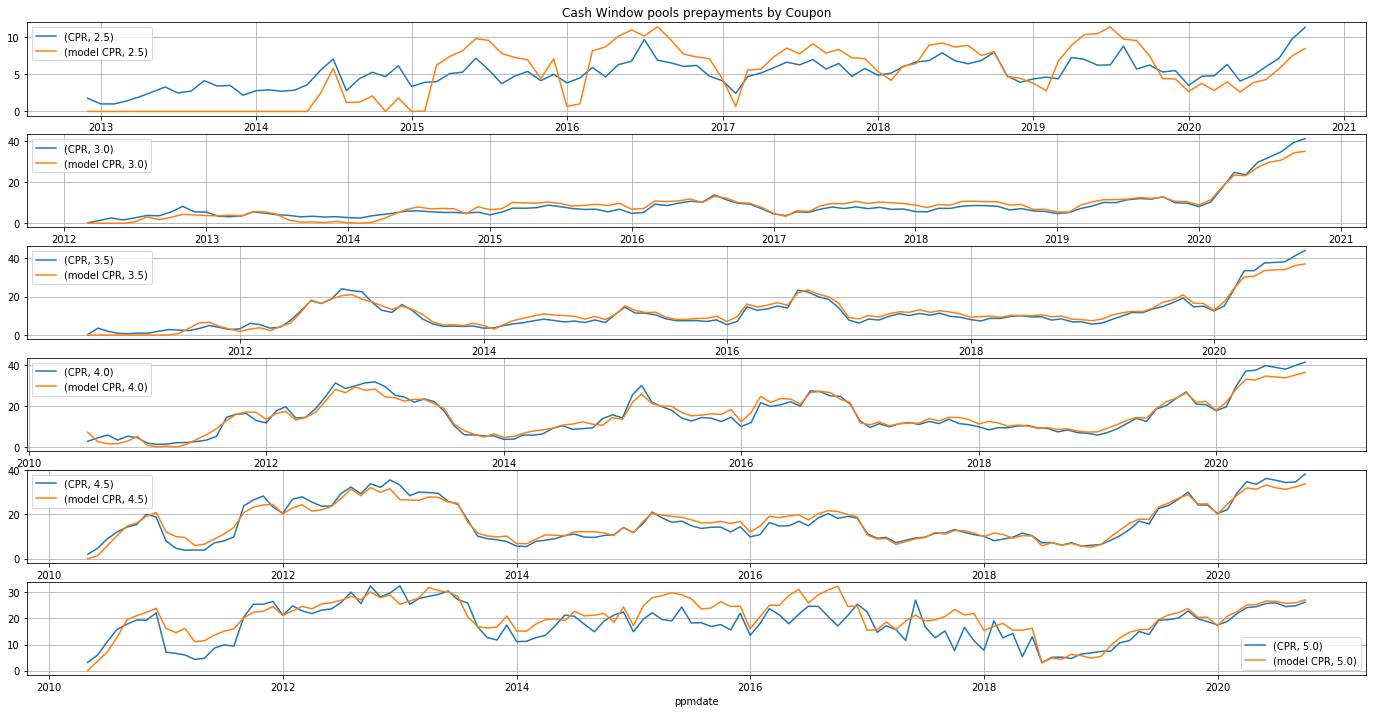

In [37]:
valReport(df[(df['cnloans']>=cnloans) & (df['%CashWindow'] == 100) & (df['Vintage'] > 2009)],graphTitle='Cash Window pools prepayments by Coupon',fsize=(24,12),lcoup=2.5,hcoup=5)

In [38]:
np.round(rmse_by_coupon(df[(df['cnloans']>=cnloans) & (df['asofdate']>=data_cutoff) & (df['%CashWindow'] == 100)],col_name='Cash Window - NN RMSE (CPR)'),2)

,Cash Window - NN RMSE (CPR)
Coupon,
2.5,2.00
3.0,2.16
3.5,2.41
4.0,2.48
4.5,1.89
5.0,2.80


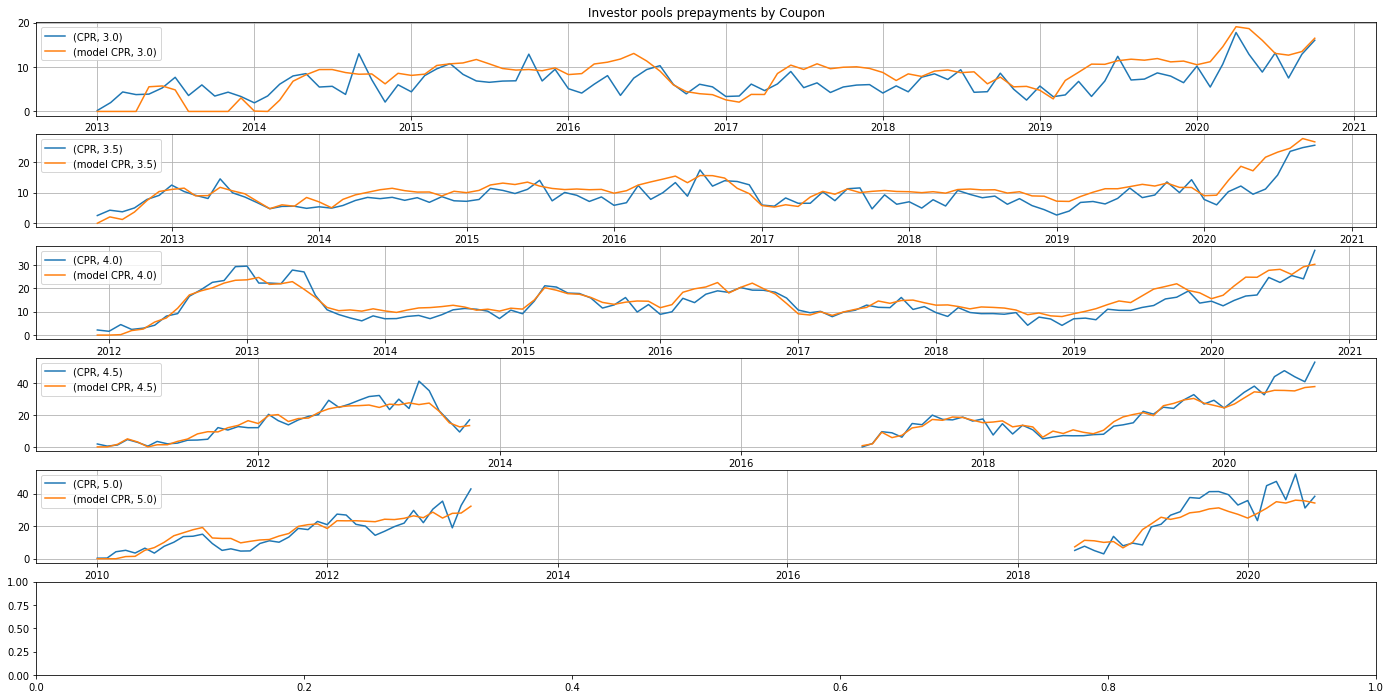

In [39]:
valReport(df[(df['cnloans']>=cnloans) & (df['OccPct_investor'] > 99) & (df['Vintage'] > 2009)],graphTitle='Investor pools prepayments by Coupon',fsize=(24,12),lcoup=3,hcoup=5.5)

In [40]:
np.round(rmse_by_coupon(df[(df['cnloans']>=cnloans) & (df['asofdate']>=data_cutoff) & (df['OccPct_investor'] > 99)],col_name='Investor - NN RMSE (CPR)'),2)

,Investor - NN RMSE (CPR)
Coupon,
2.5,2.05
3.0,3.47
3.5,3.99
4.0,4.23
4.5,4.89
5.0,7.67


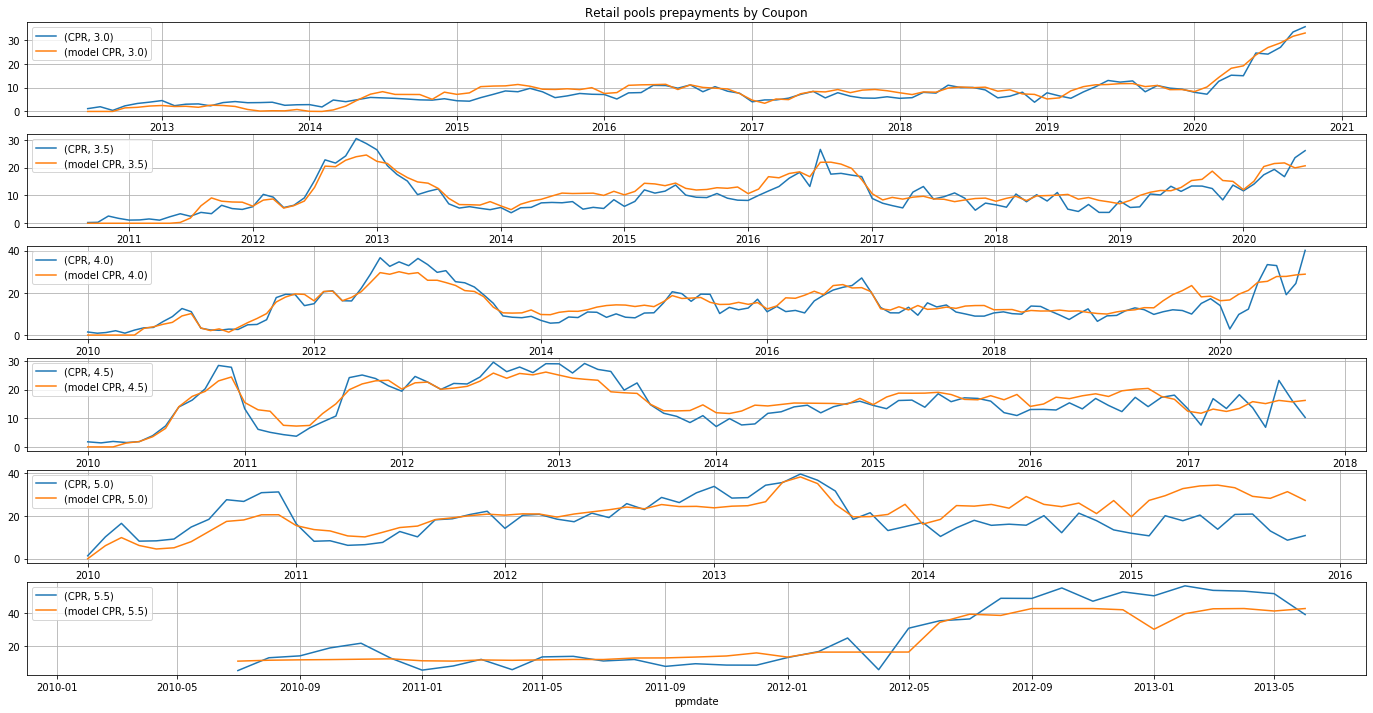

In [41]:
valReport(df[(df['cnloans']>=cnloans) & (df['PctChannel_Retail'] > 99) & (df['Vintage'] > 2009)],graphTitle='Retail pools prepayments by Coupon',fsize=(24,12),lcoup=3,hcoup=5.5)

In [42]:
np.round(rmse_by_coupon(df[(df['cnloans']>=cnloans) & (df['asofdate']>=data_cutoff) & (df['PctChannel_Retail'] > 99)],col_name='Retail - NN RMSE (CPR)'),2)

,Retail - NN RMSE (CPR)
Coupon,
2.5,4.10
3.0,1.95
3.5,3.21
4.0,5.69


## Let's try predictions on concrete bonds!

In [114]:
bonds = pd.read_csv('../agency book prepayments by bond.csv')

In [115]:
num_columns = ['OBal','CBal','OLnsz','CLnsz','aols','waols','ONLoans','cnloans']

bonds[num_columns] = bonds[num_columns].applymap(lambda x: str(x))
bonds[num_columns] = bonds[num_columns].applymap(lambda x: x.replace(",",""))
bonds[num_columns] = bonds[num_columns].applymap(lambda x: float(x))

In [116]:
bonds.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 116 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   by_remic            155 non-null    object 
 1   Asofdate            155 non-null    object 
 2   Cpr1                155 non-null    float64
 3   Cpr3                134 non-null    float64
 4   Cpr6                120 non-null    float64
 5   Cpr12               98 non-null     float64
 6   Cpr24               86 non-null     float64
 7   CprLife             155 non-null    float64
 8   SMM                 155 non-null    float64
 9   OBal                155 non-null    float64
 10  CBal                155 non-null    float64
 11  factor              155 non-null    float64
 12  OCoupon             155 non-null    float64
 13  Coupon              155 non-null    float64
 14  OWac                155 non-null    float64
 15  Wac                 155 non-null    float64
 16  Wam    

In [117]:
bonds['jumbo_flag'] = bonds['aols'].apply(lambda x: 1 if x>500000 else 0)

In [119]:
bonds['ocltv'] = bonds['oltv']
bonds['ccltv'] = bonds['cltv']

In [120]:
bonds['Seasonality'] = bonds['Asofdate'].apply(lambda x: int(x.replace(" ","").replace("'","")[-2:]))

In [121]:
bonds[['Asofdate','Seasonality']].head()

,Asofdate,Seasonality
0,' 202009,9
1,' 202010,10
2,' 202009,9
3,' 202010,10
4,' 202008,8


In [122]:
dummies = pd.get_dummies(bonds['Seasonality'],drop_first=True)
bonds = bonds.drop('Seasonality',axis=1)
bonds = pd.concat([bonds,dummies],axis=1)

print(f'bonds.shape = {bonds.shape}')

bonds.shape = (155, 128)


In [123]:
 for m in [2,3,4,5,6,7,8,9,10,11,12]:
        if m not in bonds.columns:
            bonds[m] = 0
            
print(f'bonds.shape = {bonds.shape}')            

bonds.shape = (155, 130)


In [124]:
for col in model_columns:
    if col not in bonds.columns:
        print(col)

asofdate
DayCount


In [125]:
bonds['Asofdate'].head()

0    '  202009
1    '  202010
2    '  202009
3    '  202010
4    '  202008
Name: Asofdate, dtype: object

In [126]:
bonds.rename(columns={'Asofdate':'asofdate','by_remic':'cusip'},inplace=True)

In [127]:
bonds['cusip'] = bonds['cusip'].apply(lambda x: x.replace("'",""))

In [128]:
bonds['asofdate'] = bonds['asofdate'].apply(lambda x: int(x.replace(" ","").replace("'","")))

In [129]:
bonds['asofdate'].head()

0    202009
1    202010
2    202009
3    202010
4    202008
Name: asofdate, dtype: int64

In [130]:
for col in model_columns:
    if col not in bonds.columns:
        print(col)

DayCount


In [131]:
bonds['DayCount'] = bonds['asofdate'].apply(lambda x: df[df['asofdate'] == x]['DayCount'].iloc[0]) 

In [132]:
for col in model_columns:
    if col not in bonds.columns:
        print(col)

In [133]:
bonds[['asofdate','DayCount']].head(10)

,asofdate,DayCount
0,202009,21.0
1,202010,21.0
2,202009,21.0
3,202010,21.0
4,202008,21.0
5,202009,21.0
6,202010,21.0
7,202001,21.0
8,202002,19.0
9,202003,22.0


### creating dummy data for Nov 2020 predicitons

In [134]:
nov = bonds[bonds['asofdate'] == 202010].copy()

In [135]:
nov['asofdate'] = 202011

In [136]:
nov['DayCount'] = 19

In [137]:
nov[['asofdate','DayCount']].head()

,asofdate,DayCount
1,202011,19
3,202011,19
6,202011,19
16,202011,19
23,202011,19


In [138]:
nov['spread'] += 5

In [139]:
bonds = bonds.append(nov,ignore_index=True)

In [140]:
bonds['asofdate'].unique()

array([202009, 202010, 202008, 202001, 202002, 202003, 202004, 202005,
       202006, 202007, 202011], dtype=int64)

### Now let's make predictions on bonds and put it all in a nice table

In [141]:
bonds['model SMM'] = model.predict(scaler.transform(bonds[model_columns].drop(['SMM','asofdate'],axis=1)))

In [142]:
bonds[bonds['asofdate'] == 202010][['SMM','model SMM']]

,SMM,model SMM
1,0.51,0.946208
3,0.51,0.946208
6,1.30,1.010005
16,1.03,0.972556
23,1.50,0.993437
33,3.21,2.270269
43,2.77,2.977924
53,2.90,2.746560
63,4.49,3.781500
73,4.46,2.673603


In [143]:
book = pd.read_excel('../agency book.xlsx')
book.dropna(inplace=True)

In [144]:
book.head()

,cusip,Description,Ticker
1,3136BCJH4,strip IO off Jumbo 2s,FNR 2020-75 BI
2,3136BCUZ1,strip IIO off Jumbo 2s,FNR 20-77 CS
5,3136BCJE1,strip IO off Jumbo 2.5s,FNR 2020-75 JI
6,3136BCWR7,strip IO off Jumbo 2.5s,FNR 2020-77 EI
7,3136BCUU2,PAC IO off Jumbo 2.5s,FNR 2020-77 IP


In [145]:
bonds = bonds.merge(book,on='cusip')

In [146]:
bonds['model Cpr1'] = 100*(1 - (1 - bonds['model SMM']/100)**12)

In [ ]:
# bonds[bonds['asofdate'] == 202010][['Ticker','cusip','Description','cnloans','spread','SMM','model SMM','Cpr1','model Cpr1']]

In [153]:
report = bonds[bonds['asofdate'] == 202011][['Coupon','Ticker','cusip','Description','cnloans','Age','spread','model Cpr1']]

In [154]:
report.to_csv('../model_predictions.csv',index=False)

In [155]:
report

,Coupon,Ticker,cusip,Description,cnloans,Age,spread,model Cpr1
2,2.5,FHR 5027 PI,3137FWQE3,PAC IO off Jumbo 2.5s,169.0,3,51.3,10.823488
5,2.5,FHR 5040 TI,3137F6QQ3,PAC IO off Jumbo 2.5s,196.0,3,51.3,10.823488
9,2.5,FHR 5038 IA,3137FXMX3,PAC IO off Jumbo 2.5s,167.0,3,53.5,11.460906
20,3.0,FHR 4984 EI,3137FTQB6,PAC IO off HLB 3s,545.0,9,88.3,10.700417
28,3.0,FHR 5019 KI,3137FXJ58,PAC strip IO off HLB2 3s,594.0,7,82.1,10.657013
39,3.5,FHR 4150 IO,3137AY4Y4,strip IO off HLB2 3.5s,505.0,96,122.4,20.137899
50,4.0,FHR 5010 WI,3137FVRM6,strip IO off HLB 4s,888.0,33,158.4,29.717154
61,4.5,FHR 4715 SA,3137F2X68,strip IIO off HLB2 4.5s,145.0,50,214.1,28.040987
72,4.5,FHR 4863 S,3137FL4T8,strip IIO off TBA 4.5s,143.0,28,225.8,38.523346
83,5.0,FHR 4980 IK,3137FTKE6,strip IO off HLB2 5s,483.0,20,274.4,27.823532


### Save the neural network prepayment model in .h5 format

In [156]:
from tensorflow.keras.models import load_model

In [157]:
model_name = '30yr_fixed (conf & jumbo).h5'

#### Uncomment the line below if you would like to save

In [158]:
model.save(model_name)

#### Uncomment the line below if you would like to load the model saved in Git repository

In [ ]:
# model = load_model('nn-ppm-from-csv.h5')

#### Section below is still under development

In [ ]:
# import kerastuner as kt 

In [ ]:
# def model_builder(hp):

#     model = Sequential()
    
#     #input layer / first hidden layer

#     first_layer_neurons      = hp.Int('layer_1_units', min_value=32, max_value = 1024, step = 32)
#     first_layer_dropout_rate = hp.Float('layer_1_dropout_rate', min_value = 0, max_value = 0.5, step = 0.1)

#     model.add(Dense(first_layer_neurons, input_dim=X_train.shape[1], activation='relu'))
#     model.add(Dropout(first_layer_dropout_rate))

#     # 2nd layer
#     second_layer_neurons      = hp.Int('layer_2_units', min_value=128, max_value = 512, step = 32)
#     second_layer_dropout_rate = hp.Float('layer_2_dropout_rate', min_value = 0, max_value = 0.5, step = 0.1)

#     model.add(Dense(second_layer_neurons, activation='relu'))
#     model.add(Dropout(second_layer_dropout_rate))

#     # 3rd layer
#     third_layer_neurons      = hp.Int('layer_3_units', min_value=64, max_value = 256, step = 32)
#     third_layer_dropout_rate = hp.Float('layer_3_dropout_rate', min_value = 0, max_value = 0.5, step = 0.1)

#     model.add(Dense(third_layer_neurons, activation='relu'))
#     model.add(Dropout(third_layer_dropout_rate))

#     # 4th layer
#     forth_layer_neurons      = hp.Int('layer_4_units', min_value=32, max_value = 128, step = 32)
#     forth_layer_dropout_rate = hp.Float('layer_4_dropout_rate', min_value = 0, max_value = 0.5, step = 0.1)

#     model.add(Dense(forth_layer_neurons, activation='relu'))
#     model.add(Dropout(forth_layer_dropout_rate))

#     #output layer
#     model.add(Dense(1, activation='relu')) # relu activation is perfect here, because SMM cannot be negative

#     model.compile(optimizer='adam', loss='mse')
#     #model.compile(optimizer='rmsprop', loss='mse')    

#     return model

In [ ]:
# tuner = kt.Hyperband(model_builder,
#                      objective='val_loss',
#                      max_epochs=10,
#                      hyperband_iterations=2,
#                      directory=os.path.normpath('C:/'),
#                      project_name='nn_ppm_model-' + dt.datetime.now().strftime('%Y-%M-%d-%H-%M-%S'))

In [ ]:
# tuner.search(x=X_train,
#              y=y_train,
#              validation_data=(X_test,y_test),
#              batch_size=1024,
#              epochs=10)

In [ ]:
# best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

In [ ]:
# model = tuner.hypermodel.build(best_hps)

In [ ]:
# model.summary()

In [ ]:
# tuner.results_summary()